In [4]:
import gdelt
import pandas as pd
from datetime import datetime, timedelta




here


In [5]:
gd = gdelt.gdelt()

end_date = datetime.today().strftime('%Y %b %d') 
start_date = (datetime.today() - timedelta(days=3650)).strftime('%Y %b %d')

events = gd.Search([start_date, end_date], table='events', output='pd', normcols=True, coverage=False)

print(events.columns)


Index(['globaleventid', 'sqldate', 'monthyear', 'year', 'fractiondate',
       'actor1code', 'actor1name', 'actor1countrycode', 'actor1knowngroupcode',
       'actor1ethniccode', 'actor1religion1code', 'actor1religion2code',
       'actor1type1code', 'actor1type2code', 'actor1type3code', 'actor2code',
       'actor2name', 'actor2countrycode', 'actor2knowngroupcode',
       'actor2ethniccode', 'actor2religion1code', 'actor2religion2code',
       'actor2type1code', 'actor2type2code', 'actor2type3code', 'isrootevent',
       'eventcode', 'cameocodedescription', 'eventbasecode', 'eventrootcode',
       'quadclass', 'goldsteinscale', 'nummentions', 'numsources',
       'numarticles', 'avgtone', 'actor1geotype', 'actor1geofullname',
       'actor1geocountrycode', 'actor1geoadm1code', 'actor1geoadm2code',
       'actor1geolat', 'actor1geolong', 'actor1geofeatureid', 'actor2geotype',
       'actor2geofullname', 'actor2geocountrycode', 'actor2geoadm1code',
       'actor2geoadm2code', 'actor2geo

In [33]:
unique_country_codes = events["actiongeocountrycode"].unique()
print("Unique country codes in dataset:", unique_country_codes)

southeast_asia_countries = ["TH", "MY", "RP", "ID", "CB"]  # Thailand, Malaysia, Philippines, Indonesia, Cambodia

event_codes = ["10", "11", "12", "13", "14"]

filtered_events = events[
    (events["actiongeocountrycode"].isin(southeast_asia_countries)) & 
    (events["eventrootcode"].astype(str).isin(event_codes))
]

print(filtered_events.head())




Unique country codes in dataset: ['AF' 'US' 'NI' 'UK' nan 'IS' 'EG' 'SN' 'KS' 'SA' 'AS' 'CB' 'CA' 'JO' 'CO'
 'TH' 'IN' 'CD' 'GM' 'IT' 'OD' 'BG' 'BU' 'CH' 'NG' 'ID' 'MY' 'IZ' 'CT'
 'FI' 'BE' 'UP' 'NZ' 'PM' 'CU' 'EI' 'RO' 'GR' 'FR' 'IR' 'KN' 'LY' 'SZ'
 'CM' 'SU' 'SW' 'TU' 'BR' 'PK' 'BN' 'SF' 'AR' 'HK' 'BO' 'BH' 'JA' 'PP'
 'RQ' 'ZI' 'CI' 'RS' 'ET' 'PE' 'LI' 'BL' 'MT' 'CY' 'VM' 'NO' 'CE' 'AE'
 'MD' 'AG' 'SY' 'TX' 'LE' 'MX' 'KZ' 'UG' 'BA' 'MO' 'EZ' 'MZ' 'HA' 'SO'
 'NS' 'LO' 'ML' 'JE' 'TW' 'MN' 'OS' 'MU' 'YM' 'RW' 'GH' 'SP' 'MP' 'RP'
 'DA' 'BX' 'TL' 'QA' 'NL' 'GQ' 'PO' 'AL' 'BK' 'PL' 'GT' 'IV' 'LU' 'NH'
 'TV' 'DR' 'VT' 'KU' 'MV' 'WA' 'BY' 'EN' 'CS' 'FM' 'UY' 'FJ' 'JM' 'BF'
 'GA' 'AM' 'AJ' 'SE' 'AU' 'GG' 'EC' 'GL' 'TS' 'CJ' 'VE' 'GY' 'ES' 'TZ'
 'TI' 'RI' 'BD' 'PC' 'RB' 'NP' 'EK' 'AY' 'WZ' 'YI' 'KE' 'TD' 'IM' 'WE'
 'BB' 'LG' 'NU' 'BM' 'KV' 'KR' 'PA' 'SG' 'SL' 'VC' 'LH' 'WS' 'LA' 'VQ'
 'KG' 'AC' 'MJ' 'HU' 'GK' 'AO' 'TN' 'CF' 'DJ' 'UV' 'IC' 'MI' 'TO' 'GI'
 'AQ' 'DO' 'HR' 'UZ' 'PU' 'MG' 'SI' 'NC'

In [34]:

filtered_events = filtered_events.copy()

# ✅ Rolling Mean
filtered_events.loc[:, 'nummentions_7day_avg'] = (
    filtered_events.groupby("actiongeocountrycode")['nummentions']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

country_stats = (
    filtered_events.groupby("actiongeocountrycode")['nummentions_7day_avg']
    .agg(mean_mentions='mean', std_mentions='std')
    .reset_index()
)

filtered_events = filtered_events.merge(country_stats, on="actiongeocountrycode", how="left", suffixes=('_left', '_right'))

filtered_events.drop(columns=['mean_mentions_left', 'std_mentions_left'], errors='ignore', inplace=True)
filtered_events.rename(columns={'mean_mentions_right': 'mean_mentions', 'std_mentions_right': 'std_mentions'}, inplace=True)

filtered_events.loc[:, 'std_mentions'] = filtered_events['std_mentions'].replace(0, 1e-6)

filtered_events.loc[:, 'z_score'] = (filtered_events['nummentions_7day_avg'] - filtered_events['mean_mentions']) / filtered_events['std_mentions']
filtered_events.loc[:, "log_goldstein"] = np.log1p(filtered_events["goldsteinscale"].abs())
filtered_events.loc[:, "log_tone"] = np.log1p(filtered_events["avgtone"].abs())

filtered_events.loc[:, 'social_unrest'] = (filtered_events['z_score'] > 2.576).astype(int)

print(filtered_events[['sqldate', 'actiongeocountrycode', 'nummentions', 'z_score', 'social_unrest']].head())


    sqldate actiongeocountrycode  nummentions   z_score  social_unrest
0  20150304                   MY           10  2.836295              1
1  20150304                   MY            5  1.266323              0
2  20150305                   TH           10  2.638513              1
3  20150305                   MY            6  0.952328              0
4  20150305                   MY            4  0.481336              0


In [35]:
from hmmlearn import hmm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

# ✅ Δ𝑡𝑑=10 
MIN_SAMPLES = 10  

filtered_events['sqldate'] = pd.to_datetime(filtered_events['sqldate'], format='%Y%m%d')

ten_years_ago = datetime.today() - timedelta(days=3650)
filtered_events = filtered_events[filtered_events['sqldate'] >= ten_years_ago]

print("✅ Successfully filtered data for the last 10 years.")

print(filtered_events.groupby("actiongeocountrycode")["sqldate"].count())


results = []

for country in southeast_asia_countries:
    country_data = filtered_events[filtered_events["actiongeocountrycode"] == country].copy()

    if country_data.shape[0] == 0:
        print(f"⚠️ Skipping {country}: No data available.")
        continue

    if 'goldsteinscale' in country_data.columns and 'avgtone' in country_data.columns:
        country_data.loc[:, 'log_goldstein'] = np.log1p(country_data['goldsteinscale'].abs())
        country_data.loc[:, 'log_tone'] = np.log1p(country_data['avgtone'].abs())
    else:
        print(f"⚠️ Missing required columns in {country}. Skipping.")
        continue

    country_data = country_data.infer_objects(copy=False).fillna(0)

    X = country_data[['eventrootcode', 'log_goldstein', 'log_tone']].values
    y = country_data['social_unrest'].values


    if X.shape[0] < MIN_SAMPLES or np.unique(y).size < 2:
        print(f"⚠️ Skipping {country}: Not enough samples ({X.shape[0]}) or only one class in labels.")
        continue

    # ✅ HMM 
    hmm_model = hmm.GaussianHMM(
        n_components=2,             
        covariance_type="full",      
        n_iter=2000,                
        tol=1e-1,                    
        min_covar=1e-6,
         init_params="stmc", 
        random_state=42              
    )
    hmm_model.fit(X)
    y_pred_hmm = hmm_model.predict(X)

    print(f"y_true unique values: {np.unique(y)}")
    print(f"y_pred_hmm unique values before correction: {np.unique(y_pred_hmm)}")
    y_pred_hmm = np.clip(y_pred_hmm, 0, 1)  
    print(f"y_pred_hmm unique values after correction: {np.unique(y_pred_hmm)}")

    # ✅ Logistic Regression 
    logreg = LogisticRegression()
    logreg.fit(X, y)
    y_pred_logreg = logreg.predict(X)

    # ✅ Baseline 
    y_pred_baseline = np.random.choice([0, 1], size=len(y), p=[0.9, 0.1])

    # ✅ BACC 
    bacc_hmm = balanced_accuracy_score(y, y_pred_hmm)
    bacc_logreg = balanced_accuracy_score(y, y_pred_logreg)
    bacc_baseline = balanced_accuracy_score(y, y_pred_baseline)

    results.append({"Country": country, "HMM": bacc_hmm, "LogReg": bacc_logreg, "Baseline": bacc_baseline})

results_df = pd.DataFrame(results)
print(results_df)




✅ Successfully filtered data for the last 10 years.
actiongeocountrycode
CB     624
ID    1640
MY    3412
RP    4332
TH    2453
Name: sqldate, dtype: int64
y_true unique values: [0 1]
y_pred_hmm unique values before correction: [0 1]
y_pred_hmm unique values after correction: [0 1]
y_true unique values: [0 1]
y_pred_hmm unique values before correction: [0 1]
y_pred_hmm unique values after correction: [0 1]
y_true unique values: [0 1]
y_pred_hmm unique values before correction: [0 1]
y_pred_hmm unique values after correction: [0 1]
y_true unique values: [0 1]
y_pred_hmm unique values before correction: [0 1]
y_pred_hmm unique values after correction: [0 1]
y_true unique values: [0 1]
y_pred_hmm unique values before correction: [0 1]
y_pred_hmm unique values after correction: [0 1]
  Country       HMM  LogReg  Baseline
0      TH  0.461642     0.5  0.516622
1      MY  0.550849     0.5  0.523704
2      RP  0.404890     0.5  0.451898
3      ID  0.530624     0.5  0.498667
4      CB  0.419804

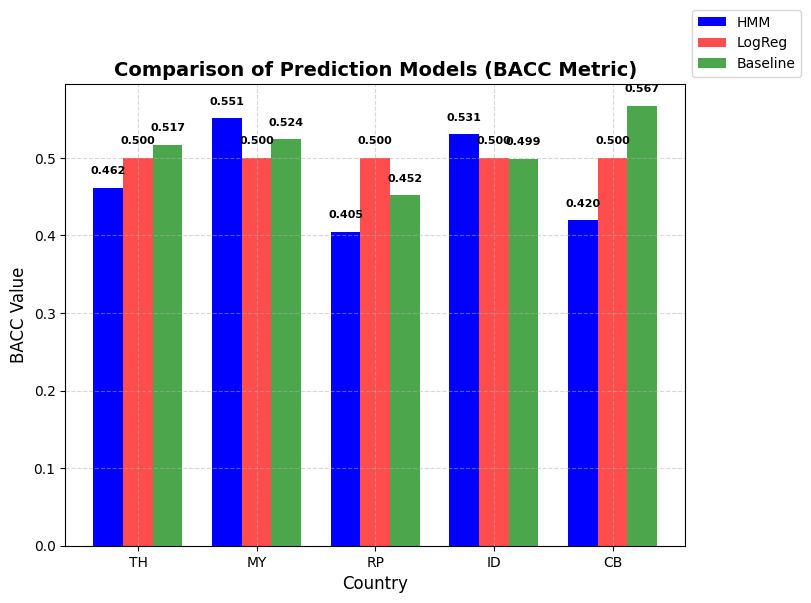

In [36]:

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,6))

bar_width = 0.25
x_labels = results_df["Country"]
x_indexes = np.arange(len(x_labels))

bars_hmm = ax.bar(x_indexes - bar_width, results_df["HMM"], width=bar_width, label="HMM", color='blue')
bars_logreg = ax.bar(x_indexes, results_df["LogReg"], width=bar_width, label="LogReg", color='red', alpha=0.7)
bars_baseline = ax.bar(x_indexes + bar_width, results_df["Baseline"], width=bar_width, label="Baseline", color='green', alpha=0.7)

for bars in [bars_hmm, bars_logreg, bars_baseline]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.015, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=8, fontweight="bold", color="black")

ax.set_ylabel("BACC Value", fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_title("Comparison of Prediction Models (BACC Metric)", fontsize=14, fontweight="bold")
ax.set_xticks(x_indexes)
ax.set_xticklabels(x_labels, fontsize=10)

ax.legend(fontsize=10, loc="lower left", bbox_to_anchor=(1, 1))

plt.grid(True, linestyle="--", alpha=0.5)

# ✅ 그래프 출력
plt.show()


TH - Sample Size: 2453
TH: AIC=-1776.06, BIC=-1706.40
MY - Sample Size: 3412
MY: AIC=-2193.90, BIC=-2120.28
RP - Sample Size: 4332
RP: AIC=-4334.27, BIC=-4257.79
ID - Sample Size: 1640
ID: AIC=-505.11, BIC=-440.28
CB - Sample Size: 624
CB: AIC=-500.92, BIC=-447.69
  Country          AIC          BIC
0      TH -1776.056189 -1706.395384
1      MY -2193.897713 -2120.277066
2      RP -4334.273499 -4257.788083
3      ID  -505.107997  -440.278579
4      CB  -500.922803  -447.688998


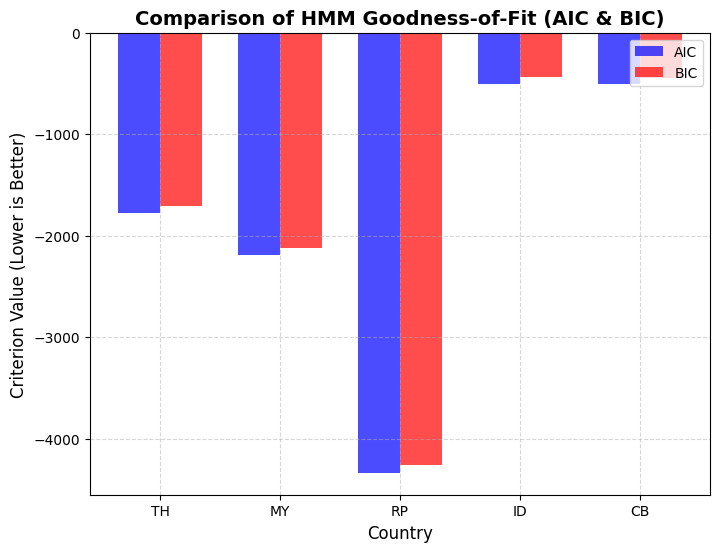

In [40]:
# ✅  AIC & BIC 
def calculate_aic_bic(hmm_model, X):
    log_likelihood = hmm_model.score(X)  
    num_params = (hmm_model.n_components ** 2) + \
                 (hmm_model.n_components * X.shape[1]) + \
                 hmm_model.n_components 

    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(len(X)) * num_params - 2 * log_likelihood
    return aic, bic


filtered_events["log_goldstein"] = np.log1p(filtered_events["goldsteinscale"].abs()).fillna(0)
filtered_events["log_tone"] = np.log1p(filtered_events["avgtone"].abs()).fillna(0)

goodness_of_fit_results = []


for country in results_df["Country"]:
    country_data = filtered_events[filtered_events["actiongeocountrycode"] == country]
    
    if country_data.empty:
        print(f"⚠️ {country}: No data available.")
        continue

    X = country_data[['eventrootcode', 'log_goldstein', 'log_tone']].values
    
    print(f"{country} - Sample Size: {X.shape[0]}")
    
    if X.shape[0] >= 1: 
        aic, bic = calculate_aic_bic(hmm_model, X)
        goodness_of_fit_results.append({"Country": country, "AIC": aic, "BIC": bic})
        print(f"{country}: AIC={aic:.2f}, BIC={bic:.2f}")
    else:
        print(f"⚠️ Skipping {country}: Not enough samples.")


goodness_of_fit_df = pd.DataFrame(goodness_of_fit_results)


if goodness_of_fit_df.empty:
    print("⚠️ No AIC/BIC data was calculated. Check sample sizes.")
else:
    print(goodness_of_fit_df)


if not goodness_of_fit_df.empty:
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8,6))
    bar_width = 0.35
    x_labels = goodness_of_fit_df["Country"]
    x_indexes = np.arange(len(x_labels))

    bars_aic = ax.bar(x_indexes - bar_width/2, goodness_of_fit_df["AIC"], width=bar_width, label="AIC", color='blue', alpha=0.7)
    bars_bic = ax.bar(x_indexes + bar_width/2, goodness_of_fit_df["BIC"], width=bar_width, label="BIC", color='red', alpha=0.7)

    ax.set_ylabel("Criterion Value (Lower is Better)", fontsize=12)
    ax.set_xlabel("Country", fontsize=12)
    ax.set_title("Comparison of HMM Goodness-of-Fit (AIC & BIC)", fontsize=14, fontweight="bold")
    ax.set_xticks(x_indexes)
    ax.set_xticklabels(x_labels, fontsize=10)

    ax.legend(fontsize=10, loc="upper right")

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()




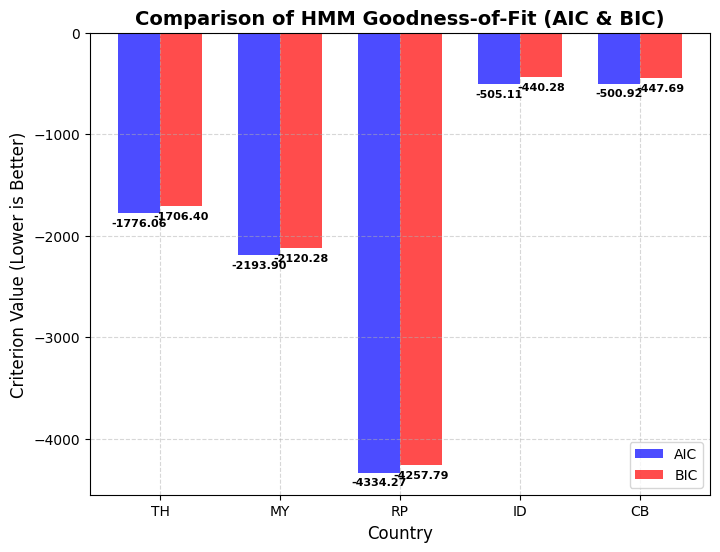

In [41]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8,6))
bar_width = 0.35
x_labels = goodness_of_fit_df["Country"]
x_indexes = np.arange(len(x_labels))


bars_aic = ax.bar(x_indexes - bar_width/2, goodness_of_fit_df["AIC"], width=bar_width, label="AIC", color='blue', alpha=0.7)
bars_bic = ax.bar(x_indexes + bar_width/2, goodness_of_fit_df["BIC"], width=bar_width, label="BIC", color='red', alpha=0.7)


for bars in [bars_aic, bars_bic]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height - 50,  
                f'{height:.2f}', ha='center', va='top', fontsize=8, fontweight="bold", color="black")

ax.set_ylabel("Criterion Value (Lower is Better)", fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_title("Comparison of HMM Goodness-of-Fit (AIC & BIC)", fontsize=14, fontweight="bold")
ax.set_xticks(x_indexes)
ax.set_xticklabels(x_labels, fontsize=10)

ax.legend(fontsize=10, loc="lower right")


plt.grid(True, linestyle="--", alpha=0.5)


plt.show()
